# POP MOC(sigma 2) for 0.1-degree
**Input Data:** Monthly POP output timeseries files  
**Output Data:** Monthly mean AMOC z timeseries  
**Description:** Computes MOC(z) offline from POP history files using simple xhistogram binning.  
**Date:** February 2023  
**Creator:** Steve Yeager (https://github.com/sgyeager/POP_MOC/blob/main/notebooks/pop_MOCz_0.1deg.ipynb)  
**Updated:** Fred Castruccio and Teagan King, February 2023  
**Note:** To use the MOCutils, a user will need to clone the POP_MOC repository (https://github.com/sgyeager/POP_MOC) and install MOCutils by going to the POP_MOC directory and running `pip install -e . --user`.

In [8]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import glob
import dask
from xhistogram.xarray import histogram
import matplotlib.pyplot as plt
%matplotlib inline

from MOCutils import popmoc
import pop_tools

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dask.distributed import wait
dask.__version__

'2022.7.0'

In [3]:
# Close out Dask Cluster and release workers:
#cluster.close()
#client.close()

In [4]:
# TODO: optimize dask resources

def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        accon='NCGD0011',
        walltime='06:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(72) 

/glade/u/home/tking/.conda/envs/ipogs/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/home/tking/.conda/envs/ipogs/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33620 instead
  warnings.warn(
/glade/u/home/tking/.conda/envs/ipogs/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now

In [9]:
cluster

PBSCluster(89e673e9, 'tcp://10.12.206.48:37117', workers=50, threads=50, memory=500.00 GiB)

In [3]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

# Get the required variables 

In [5]:
#fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002/ocn/proc/tseries/month_1/'
#fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003/ocn/proc/tseries/month_1/'
#fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP45/HR/b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'
fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP26/HR/b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'

#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002.pop.h.VVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003.pop.h.VVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'
fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'
dsV = xr.open_dataset(fin, chunks={'time':1,'nlon':100})
dsV = time_set_midmonth(dsV,'time')

#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002.pop.h.WVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003.pop.h.WVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.WVEL.200601-210012.nc'
fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.WVEL.200601-210012.nc'
dsW = xr.open_dataset(fin, chunks={'time':1,'nlon':100})
dsW = time_set_midmonth(dsW,'time')

fgrd = '/glade/work/fredc/cesm/grid/POP/grid.3600x2400x62.nc'
ds_grid = xr.open_dataset(fgrd)
#ds_grid = pop_tools.get_grid('/glade/work/fredc/cesm/grid/POP/grid.3600x2400x62.nc')

fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

In [10]:
%%time

dz = ds_grid['dz'].persist() / 100.
print('got dz')

kmt = ds_grid['KMT'].fillna(0).persist() 
print('got kmt')

# Slow step. Not using dask here. 13 mins previously. 17 mins now with full dataset
dzt,dzu = popmoc.tx0p1v3_dztdzu(dz,kmt)
print('got dzt dzu')

got dz
got kmt
got dzt dzu
CPU times: user 1min 27s, sys: 5min 45s, total: 7min 13s
Wall time: 17min 8s


#### 2. Compute sigma-2 field from POP model output

In [14]:
dsV

<xarray.Dataset>
Dimensions:             (z_t: 62, z_t_150m: 15, z_w: 62, z_w_top: 62,
                         z_w_bot: 62, nlat: 2400, nlon: 3600, time: 1140, d2: 2)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
  * time                (time) object 2006-01-15 00:00:00 ... 2100-12-15 00:0...
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 2400, 100), meta=np.ndarray>
Attributes:
    title:         b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2022-05-27 at 07:42:02.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  19331
    tavg_sum:      2676600.0

In [17]:
dsW

<xarray.Dataset>
Dimensions:             (z_t: 62, z_t_150m: 15, z_w: 62, z_w_top: 62,
                         z_w_bot: 62, nlat: 2400, nlon: 3600, time: 1140, d2: 2)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
  * time                (time) object 2006-01-15 00:00:00 ... 2100-12-15 00:0...
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 100), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    WVEL                (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 2400, 100), meta=np.ndarray>
Attributes:
    title:         b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2022-05-27 at 07:42:02.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  19331
    tavg_sum:      2676600.0

In [21]:
dsV.variables

Frozen({'z_t': <xarray.IndexVariable 'z_t' (z_t: 62)>
array([5.000000e+02, 1.500000e+03, 2.500000e+03, 3.500000e+03, 4.500000e+03,
       5.500000e+03, 6.500000e+03, 7.500000e+03, 8.500000e+03, 9.500000e+03,
       1.050000e+04, 1.150000e+04, 1.250000e+04, 1.350000e+04, 1.450000e+04,
       1.550000e+04, 1.650984e+04, 1.754790e+04, 1.862913e+04, 1.976603e+04,
       2.097114e+04, 2.225783e+04, 2.364088e+04, 2.513702e+04, 2.676542e+04,
       2.854837e+04, 3.051192e+04, 3.268680e+04, 3.510935e+04, 3.782276e+04,
       4.087846e+04, 4.433777e+04, 4.827367e+04, 5.277280e+04, 5.793729e+04,
       6.388626e+04, 7.075633e+04, 7.870025e+04, 8.788252e+04, 9.847059e+04,
       1.106204e+05, 1.244567e+05, 1.400497e+05, 1.573946e+05, 1.764003e+05,
       1.968944e+05, 2.186457e+05, 2.413972e+05, 2.649001e+05, 2.889385e+05,
       3.133405e+05, 3.379793e+05, 3.627670e+05, 3.876452e+05, 4.125768e+05,
       4.375392e+05, 4.625190e+05, 4.875083e+05, 5.125028e+05, 5.375000e+05,
       5.624991e+05, 5

In [19]:
# Get model T & S
# salt = ds['SALT']
# temp = ds['TEMP']

# SALT is mean Salinity in gram/kilogram over coords time z_t nlat nlon
# TEMP is mean Potential Temperature in degC over coords time z_t nlat nlon
# https://www.cesm.ucar.edu/community-projects/lens2/output-variables

# TODO: These are conversion factors, not actual values...
salt = dsV['salt_to_mmday']
temp = dsV['T0_Kelvin']

In [22]:
%%time
refz = 2000
# TODO: Does it matter if the below cell uses dsV or dsW?
refdep = xr.full_like(dsV['z_t'],refz).rename('REFDEP')

# Sigma2 on model TLAT, TLONG
sigma2_T = pop_tools.eos(salt=salt,temp=temp,depth=refdep) - 1000
sigma2_T = sigma2_T.assign_attrs({'long_name':'Sigma referenced to {}m'.format(refz),'units':'kg/m^3'})

CPU times: user 30.1 ms, sys: 6.35 ms, total: 36.5 ms
Wall time: 480 ms


In [25]:
refdep
# TODO: This seems odd that it's all the same value?

<xarray.DataArray 'REFDEP' (z_t: 62)>
array([2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
Attributes:
    long_name:  depth from surface to midpoint of layer
    units:      centimeters
    positive:   down
    valid_min:  500.0
    valid_max:  587499.06

eos:  
    Compute density as a function of salinity, temperature, and
    depth (or pressure).
    McDougall, T.J., D.R. Jackett, D.G. Wright, and R. Feistel, 2003:
    Accurate and Computationally Efficient Algorithms for Potential
    Temperature and Density of Seawater. J. Atmos. Oceanic Technol., 20,
    730–741, _`https://doi.org/10.1175/1520-0426(2003)20<730:AACEAF>2.0.CO;2`.
    test value:
        rho = 1033.213387 kg/m^3;
        S = 35.0 PSU, theta = 20.0 C, pressure = 2000.0 dbars  
    Parameters  
    ----------  
    salt : float
        salinity, psu
    temp : float
        potential temperature, degree C
    return_coefs : boolean, optional [default=False]
        Logical, if true function returns 2 additional arguments:
        dRHOdS and dRHOdT
    depth : float, optional
        depth in meters, if not provided, pressure must be provided.
    pressure : float, optional
        depth in dbar  
    Returns  
    -------  
    rho : float
        density kg/m^3
    dRHOdS : float, optional
        Derivative of rho with respect to salinity.
    dRHOdT : float, optional
        Derivative of rho with respect to temperature.

In [24]:
# TODO: This seems odd that it's all the same value?
sigma2_T

<xarray.DataArray 'density' (z_t: 62)>
array([270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036, 270.74671036, 270.74671036,
       270.74671036, 270.74671036])
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
Attributes:
    long_name:  Sigma referenced to 2000m
    units:      kg/m^3

#### 3. Define target sigma-2 vertical grid
Use a predefined target grid, or create your own!

In [28]:
# Use predefined 86-layer sigma2 grid:
sigma_mid,sigma_edge = popmoc.sigma2_grid_86L()

In [29]:
sigma_mid

<xarray.DataArray (sigma: 86)>
array([28.  , 28.2 , 28.4 , 28.6 , 28.8 , 29.  , 29.2 , 29.4 , 29.6 ,
       29.8 , 30.  , 30.2 , 30.4 , 30.6 , 30.8 , 31.  , 31.2 , 31.4 ,
       31.6 , 31.8 , 32.  , 32.2 , 32.4 , 32.6 , 32.8 , 33.  , 33.2 ,
       33.4 , 33.6 , 33.8 , 34.  , 34.2 , 34.4 , 34.6 , 34.8 , 35.  ,
       35.1 , 35.2 , 35.3 , 35.4 , 35.5 , 35.6 , 35.7 , 35.8 , 35.9 ,
       36.  , 36.05, 36.1 , 36.15, 36.2 , 36.25, 36.3 , 36.35, 36.4 ,
       36.45, 36.5 , 36.55, 36.6 , 36.65, 36.7 , 36.75, 36.8 , 36.85,
       36.9 , 36.95, 37.  , 37.05, 37.1 , 37.15, 37.2 , 37.25, 37.3 ,
       37.35, 37.4 , 37.45, 37.5 , 37.55, 37.6 , 37.65, 37.7 , 37.75,
       37.8 , 37.85, 37.9 , 37.95, 38.  ], dtype=float32)
Coordinates:
  * sigma    (sigma) float32 28.0 28.2 28.4 28.6 28.8 ... 37.85 37.9 37.95 38.0
Attributes:
    long_name:  Sigma2 at middle of layer
    units:      kg/m^3

In [30]:
sigma_edge

<xarray.DataArray (sigma: 87)>
array([ 0.      , 28.1     , 28.3     , 28.5     , 28.7     , 28.9     ,
       29.1     , 29.3     , 29.5     , 29.7     , 29.9     , 30.1     ,
       30.3     , 30.5     , 30.7     , 30.9     , 31.1     , 31.3     ,
       31.5     , 31.7     , 31.9     , 32.1     , 32.300003, 32.5     ,
       32.699997, 32.9     , 33.1     , 33.300003, 33.5     , 33.699997,
       33.9     , 34.1     , 34.300003, 34.5     , 34.699997, 34.9     ,
       35.05    , 35.15    , 35.25    , 35.35    , 35.45    , 35.55    ,
       35.65    , 35.75    , 35.85    , 35.95    , 36.025   , 36.074997,
       36.125   , 36.175003, 36.225   , 36.275   , 36.324997, 36.375   ,
       36.425003, 36.475   , 36.525   , 36.574997, 36.625   , 36.675003,
       36.725   , 36.775   , 36.824997, 36.875   , 36.925003, 36.975   ,
       37.025   , 37.074997, 37.125   , 37.175003, 37.225   , 37.275   ,
       37.324997, 37.375   , 37.425003, 37.475   , 37.525   , 37.574997,
       37.625   , 37.675003, 37.725   , 37.775   , 37.824997, 37.875   ,
       37.925003, 37.975   , 50.      ], dtype=float32)
Coordinates:
  * sigma    (sigma) float32 0.0 28.1 28.3 28.5 28.7 ... 37.88 37.93 37.97 50.0
Attributes:
    long_name:  Sigma2 at edges of layer
    units:      kg/m^3

#### 4. Compute Isopycnal Layer Thickness (Can skip if not needed)

In [31]:
%%time
# Here, test histogram by counting cells in each density bin. Vertical sum should be same as KMT.
iso_count = histogram(sigma2_T, bins=[sigma_edge.values],dim=['z_t'],density=False)
iso_count = iso_count.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

kmtdiff = iso_count.sum('sigma') - ds_grid['KMT']
print("Max difference from true KMT = {}".format(abs(kmtdiff).max().values))

Max difference from true KMT = 62.0
CPU times: user 96.4 ms, sys: 149 ms, total: 245 ms
Wall time: 401 ms


In [34]:
%%time
# Use histogram to compute layer thickness. Vertical sum should be same as HT.
iso_thick = histogram(sigma2_T, bins=[sigma_edge.values], weights=dzt,dim=['z_t'],density=False)
iso_thick = iso_thick.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_thick = iso_thick.rename('iso_thick').assign_attrs({'units':'m','long_name':'Isopycnal Layer Thickness'}).rename({'sigma':'sigma_mid'})

CPU times: user 26.6 s, sys: 1min 56s, total: 2min 23s
Wall time: 7min 16s


In [35]:
iso_thick

<xarray.DataArray 'iso_thick' (nlat: 2400, nlon: 3600, sigma_mid: 86)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * sigma_mid  (sigma_mid) float32 28.0 28.2 28.4 28.6 ... 37.85 37.9 37.95 38.0
Dimensions without coordinates: nlat, nlon
Attributes:
    units:      m
    long_name:  Isopycnal Layer Thickness

In [36]:
iso_thick = iso_thick.transpose('sigma_mid','nlat','nlon')

In [37]:
%%time
# takes somewhat long time to run this cell... it's also not really using dask.
htdiff = iso_thick.sum('sigma_mid') - (ds_grid['HT']/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

Max difference from true HT = 5999.990363999998m


#### 5. Compute Isopycnal Layer Depth (Can skip if not needed)

In [38]:
%%time
# Cumulative sum of layer thickness yields depth of layer edges:
iso_depth = iso_thick.cumsum('sigma_mid').rename('iso_depth').rename({'sigma_mid':'sigma_bot'}).assign_attrs({'units':'m','long_name':'Isopycnal Layer Depth'})
sigma_bot = sigma_edge.isel(sigma=slice(1,None)).rename({'sigma':'sigma_bot'}).assign_attrs({'long_name':'Sigma2 at bottom of layer'})
iso_depth['sigma_bot'] = sigma_bot
iso_depth = iso_depth.transpose('sigma_bot','nlat','nlon')

CPU times: user 25.9 s, sys: 1min 54s, total: 2min 20s
Wall time: 7min 9s


In [39]:
iso_depth

<xarray.DataArray 'iso_depth' (sigma_bot: 86, nlat: 2400, nlon: 3600)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * sigma_bot  (sigma_bot) float32 28.1 28.3 28.5 28.7 ... 37.93 37.97 50.0
Dimensions without coordinates: nlat, nlon
Attributes:
    units:      m
    long_name:  Isopycnal Layer Depth

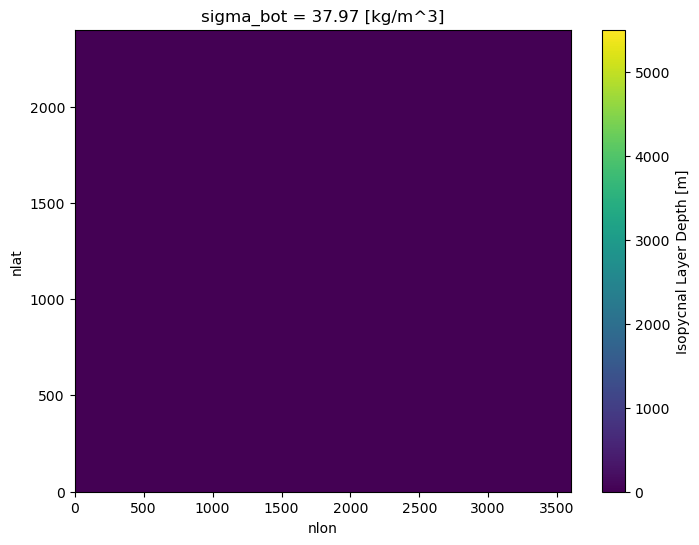

In [40]:
%%time
iso_depth.isel(sigma_bot=84).plot(size=6,vmax=5500)

In [41]:
%%time
# Isopycnal depth of bottom-most layer should be same as HT.
htdiff =  iso_depth.isel(sigma_bot=-1) - (ds_grid['HT']/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

Max difference from true HT = 5999.990363999998m
CPU times: user 9.04 s, sys: 27.2 s, total: 36.2 s
Wall time: 1min 52s


#### 6. Compute Isopycnal Layer Horizontal Volume Flux

In [42]:
## Grid Metrics
dxu = ds_grid['DXU']
dyu = ds_grid['DYU']
dxt = ds_grid['DXT']
dyt = ds_grid['DYT']

In [45]:
# TODO: don't have UVEL, but have WVEL?
# u_e = ds['UVEL']
# u_e = u_e.where(u_e<1.e30,0)
v_e = dsV['VVEL']
v_e = v_e.where(v_e<1.e30,0)

In [46]:
%%time
# Grid-oriented Volume FLuxes:
# u_e = (u_e*dyu*dzu/1.e4).assign_attrs({'units':'m^3/s'})
v_e = (v_e*dxu*dzu/1.e4).assign_attrs({'units':'m^3/s'})

CPU times: user 9.85 s, sys: 9.51 s, total: 19.4 s
Wall time: 51.7 s


In [47]:
%%time
# Convert u_e,v_e to C-grid fluxes
# u = 0.5*(u_e+u_e.shift(nlat=1))
v = 0.5*(v_e+v_e.roll(nlon=1,roll_coords=False))

CPU times: user 1.04 s, sys: 510 ms, total: 1.55 s
Wall time: 5.04 s


In [48]:
%%time
# Volume fluxes in density-space. 
# iso_uflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=u,dim=['z_t'],density=False)
# iso_uflux = iso_uflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

iso_vflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=v,dim=['z_t'],density=False)
iso_vflux = iso_vflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

CPU times: user 628 ms, sys: 39 ms, total: 667 ms
Wall time: 807 ms


In [ ]:
%%time
iso_uflux = iso_uflux.persist()
daskout = wait(iso_uflux)

In [49]:
%%time
iso_vflux = iso_vflux.persist()
daskout = wait(iso_vflux)

CancelledError: [('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 887, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 212, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 738, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 249, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 513, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1082, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 641, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1041, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 844, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 158, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 404, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 270, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 504, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 34, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 846, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 833, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 394, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 698, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 409, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 779, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1080, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 511, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 385, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 763, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 397, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 232, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 863, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 847, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1099, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 191, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 849, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 202, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 760, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 346, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 399, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 850, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 798, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 229, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 303, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 112, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 529, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1015, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 837, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 284, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 765, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 190, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 501, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 201, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 881, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 998, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1073, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 185, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1101, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1027, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1097, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 466, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 93, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 493, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 410, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 329, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 702, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 626, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 643, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1060, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 172, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 568, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 835, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 729, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1071, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 216, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 577, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 802, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 477, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 319, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 461, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 746, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 521, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 255, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 638, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 296, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 472, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 538, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 313, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 935, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 774, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 549, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 522, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 946, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 621, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 813, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 588, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 632, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 830, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 605, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 841, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 730, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 858, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1138, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 333, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 564, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 114, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1103, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 52, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 220, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 316, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 634, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 545, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 662, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 722, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 640, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 937, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 777, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 130, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 15, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 848, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 914, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 938, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 396, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 347, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 977, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 263, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 334, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1113, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 391, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 291, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 688, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 913, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 851, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 791, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 566, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 12, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 751, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 309, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 41, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 526, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 654, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 554, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 445, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 96, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 429, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 36, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 129, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 380, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1100, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 155, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1076, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 188, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1087, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 455, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 952, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 71, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 104, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 91, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 502, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 11, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 405, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 147, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 264, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 713, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 927, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 389, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 589, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 331, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 933, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 439, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 505, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 622, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 516, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 375, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 781, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 65, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 101, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 659, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 984, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 767, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 956, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 995, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 113, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 967, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 226, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 467, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 253, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1092, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1125, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 867, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 660, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 435, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 210, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1120, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 895, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 670, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 710, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 518, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 584, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 359, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 776, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 562, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 551, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 337, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 787, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 573, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 462, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 546, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 237, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 579, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 321, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1062, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 557, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 332, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 770, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 854, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 629, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 865, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 646, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 904, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 140, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 979, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 754, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 882, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 657, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 782, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 141, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 196, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1079, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 357, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 593, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 335, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 674, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1090, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 235, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 893, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 994, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 571, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 829, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 447, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 222, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 139, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 741, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 424, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 166, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 924, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 199, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1038, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 283, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 58, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 136, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 941, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1049, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 75, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 986, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 761, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1133, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 824, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1058, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 150, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 183, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 591, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1119, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1066, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 406, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 925, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 419, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 989, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 161, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1022, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 194, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1006, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 383, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 348, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 716, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 123, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 178, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 684, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 491, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 211, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 233, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 137, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 575, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 213, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 608, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 330, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 475, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 727, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 246, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 469, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 508, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 413, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 586, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 649, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 700, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 267, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 744, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 519, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 616, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 8, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 497, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 244, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 272, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 902, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 827, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 569, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 911, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 47, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 186, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 69, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1025, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 227, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1019, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 800, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 481, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1085, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1003, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 197, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 778, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 860, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 811, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 861, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 603, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 378, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1036, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 170, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 838, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 795, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1069, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 855, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 580, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 678, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 806, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 697, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1086, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 695, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 822, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1136, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 153, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 630, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 839, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 489, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 231, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 706, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1052, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 209, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 872, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 164, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 248, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 506, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 28, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1063, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1114, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 259, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 922, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 148, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 556, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 111, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 939, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1115, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 175, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 208, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1047, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 342, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 159, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 320, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 192, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 450, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 225, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 681, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1130, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 326, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 456, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 483, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 50, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 672, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 864, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1075, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 117, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 275, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 451, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 500, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 242, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 617, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 665, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 392, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 599, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 725, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 897, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 709, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 484, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 797, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 134, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 517, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 601, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 292, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1033, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 468, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 775, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 808, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 495, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 583, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 814, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 528, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1044, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 350, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 792, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 567, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 825, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 600, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 819, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 594, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1017, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 803, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1116, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1001, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 809, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 250, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 595, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1028, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 25, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1012, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 908, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1045, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 486, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 261, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1029, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 478, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 720, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 820, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 804, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 37, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 454, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 245, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 704, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 919, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1112, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 162, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 859, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1111, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 892, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 978, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1129, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 146, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1117, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 470, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1089, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 157, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1011, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1095, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 679, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1056, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1128, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 145, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 690, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 903, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 262, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1032, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 4, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 807, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 987, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 361, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 707, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 920, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 156, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 734, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 368, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 553, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 982, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1048, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 160, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 453, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1059, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 173, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1043, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1046, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 570, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 345, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1013, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 721, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 464, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 705, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 581, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1024, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1008, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 356, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 686, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 45, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 370, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 48, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 878, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 26, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 10, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 739, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 131, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 465, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 21, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 207, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 23, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 701, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 351, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 240, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 142, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 362, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 352, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 379, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 154, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 840, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1106, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 115, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 687, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 407, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 873, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 597, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 896, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 671, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 132, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 604, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 126, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 682, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 789, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 917, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 365, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 692, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1031, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 143, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 349, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 124, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 24, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 440, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 366, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1042, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 215, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1023, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 559, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 817, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 592, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 874, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 293, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 907, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 2, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 35, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 32, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 290, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 652, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 343, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 19, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 268, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 877, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 619, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 552, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 43, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 294, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 327, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 344, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 68, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 355, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 54, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 959, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 230, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 582, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 613, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 388, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 910, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 22, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 888, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 214, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 542, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 663, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 921, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1040, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 696, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 610, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 6, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 637, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 66, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 485, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 905, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 934, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 960, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 17, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 279, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 363, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 539, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 281, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 314, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 834, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 56, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 374, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 951, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 955, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 30, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 149, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 572, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 181, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 929, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 204, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 862, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 258, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 33, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1054, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 891, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 957, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 7, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1108, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 29, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 128, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 883, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 308, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 304, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 650, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 341, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 40, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 683, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 382, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 875, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 661, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 857, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 550, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 325, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 496, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 282, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 667, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 184, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 540, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 786, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 57, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 393, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 561, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 645, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 732, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 507, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 288, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 578, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 74, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 942, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 353, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 915, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1132, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 182, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 524, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 266, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 299, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 821, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 228, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 815, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 535, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 277, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 596, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 628, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 886, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 174, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 20, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 715, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1078, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 932, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 832, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 853, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 916, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 256, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1057, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 753, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 31, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 585, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 624, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 870, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 360, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 328, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 9, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 816, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 70, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 602, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 459, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 306, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 499, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 689, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 377, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 947, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 274, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 16, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 618, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 195, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 794, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 49, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 651, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 312, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 843, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 87, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 876, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 168, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 431, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 510, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 206, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 252, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 285, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 548, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 27, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 323, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 668, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 179, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1124, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 60, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 223, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 437, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 899, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 302, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 44, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 926, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 38, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 82, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 77, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 152, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 367, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 494, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 236, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 823, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 280, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 448, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 234, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 943, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 269, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 55, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 718, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 894, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 981, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 169, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 426, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 976, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 109, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 163, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 247, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 992, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 286, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 954, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 61, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 756, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1068, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 180, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 482, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 224, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 714, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 793, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 364, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 762, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 84, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 537, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 218, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 747, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 257, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 923, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 427, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 898, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 930, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 769, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 973, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 544, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 764, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1096, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 740, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 993, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 758, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1123, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1122, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1139, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 773, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 842, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1118, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 444, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 515, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 94, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 990, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 471, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 742, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1074, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 890, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1000, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 422, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 931, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1055, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 300, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1107, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 790, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 167, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 532, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 719, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 200, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 831, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1135, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 565, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1039, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 307, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1083, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 89, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 151, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 340, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 796, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 421, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 122, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 217, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 673, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 415, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1061, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 135, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1050, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 543, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 836, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 420, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 757, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 780, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 318, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 555, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 733, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 432, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 731, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 615, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1034, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 193, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1067, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1077, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 449, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 711, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1094, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1105, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 525, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 880, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 443, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 828, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1072, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 527, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1005, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 503, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 983, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1065, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 509, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1016, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 492, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 558, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 560, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 278, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 685, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 965, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1014, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 243, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 425, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 458, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 460, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 728, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 376, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 587, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 442, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 906, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 694, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 712, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1131, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 436, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 476, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 487, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 884, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 520, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1098, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 717, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 805, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1134, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 110, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 723, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1070, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 724, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 970, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 120, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 676, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 745, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 852, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1020, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1009, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1030, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 127, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 845, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 395, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 627, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 784, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 953, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1053, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 198, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1126, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 423, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 868, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 648, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 912, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 735, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 772, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1084, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 473, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1026, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 105, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 856, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 107, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 768, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 948, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 118, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 390, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 418, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 138, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 165, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 310, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 102, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 401, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 801, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 635, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 885, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1064, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 576, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1081, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 752, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 826, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 5, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 759, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 879, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 438, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 534, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 918, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 88, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 737, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 693, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 726, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 971, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 121, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 818, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 297, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 743, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1037, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 39, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 812, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1051, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 72, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 171, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 968, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 909, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1010, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 99, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 402, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 949, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 691, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 785, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 67, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 85, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 177, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 80, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 305, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 116, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 358, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1021, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 144, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 966, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 479, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 655, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 708, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 221, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 369, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 83, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 633, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 324, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1093, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 666, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 205, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 386, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 408, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 42, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 15, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 644, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 271, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 677, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 533, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1110, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 108, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1104, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 59, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 86, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 463, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 336, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1004, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 985, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1088, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 103, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 238, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1018, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1121, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 480, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 936, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 273, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 251, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 771, 0, 11, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 869, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 611, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 988, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 3, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 755, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 239, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 301, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 446, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 14, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 788, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 176, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 530, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 636, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 400, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 563, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 625, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 639, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 999, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 338, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 536, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 609, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 311, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 53, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 384, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 457, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 18, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 514, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 799, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 289, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 541, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 78, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 322, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 574, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 64, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 430, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 950, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 97, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 412, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 871, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 260, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 656, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 699, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 46, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 295, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 441, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 81, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 783, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 928, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 339, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 474, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 703, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 963, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1002, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 62, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 414, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 996, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 189, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 241, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 901, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 452, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 531, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 945, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 95, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 372, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 974, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 13, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 92, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 0, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 98, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1007, 0, 26, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 79, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 749, 0, 33, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 620, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1091, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1137, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 73, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 866, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 964, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 187, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 614, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 980, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 63, 0, 32, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 766, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 997, 0, 28, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 125, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 76, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 90, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 119, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 403, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 680, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 598, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 958, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 962, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 606, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 631, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 991, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 373, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 387, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 416, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 381, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 658, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1109, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 647, 0, 14, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 940, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 975, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 433, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 612, 0, 13, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 969, 0, 17, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 354, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 547, 0, 25, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 750, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 398, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 889, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1035, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1, 0, 6, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 512, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 810, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 498, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 219, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 254, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 669, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 900, 0, 1, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1127, 0, 34, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 287, 0, 35, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 411, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 642, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 590, 0, 5, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 653, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 675, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 371, 0, 22, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 417, 0, 19, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 428, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 100, 0, 8, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 203, 0, 29, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 623, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 276, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 488, 0, 4, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 748, 0, 9, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 317, 0, 30, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 490, 0, 16, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 664, 0, 3, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 133, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 523, 0, 20, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 944, 0, 10, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 265, 0, 27, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 972, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 1102, 0, 24, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 51, 0, 18, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 607, 0, 7, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 961, 0, 12, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 298, 0, 31, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 434, 0, 21, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 736, 0, 23, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 106, 0, 2, 0), ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 315, 0, 33, 0)]

In [50]:
%%time
# Vertical sum in density-space should reproduce vertical sum in depth-space
# ufluxdiff = iso_uflux.isel(time=0).sum('sigma') - u.isel(time=0).sum('z_t')
# print("Max difference from true Uflux = {}".format(abs(ufluxdiff).max().values))
vfluxdiff = iso_vflux.isel(time=0).sum('sigma') - v.isel(time=0).sum('z_t')
print("Max difference from true Vflux = {}".format(abs(vfluxdiff).max().values))

CancelledError: ('sum-aggregate-f7c8e62151bceab8d93a164e51d73593', 0, 0, 31, 0)

#### 7. Compute Vertical Volume Flux from horizontal flux convergence

In [ ]:
%%time
wflux = popmoc.wflux(iso_uflux,iso_vflux,'sigma',sigma_edge,grid='C')
wflux = wflux.assign_coords({'TLAT':ds['TLAT'],'TLONG':ds['TLONG']}).drop(['ULAT','ULONG'])

In [ ]:
%%time
wflux = wflux.persist()
daskout = wait(wflux)

#### 8. Define MOC region masks

In [ ]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

In [ ]:
rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5);

#### 9. Compute MOC

In [ ]:
%%time
MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)
MOC = MOC.transpose('transport_reg','sigma','lat_aux_grid')

In [ ]:
%%time
MOC = MOC.load()
#daskout = wait(MOC)

#### 10. Add Southern Boundary Fluxes for Atlantic Region

In [ ]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1
atl_j

In [ ]:
%%time
# add vflux at southern boundary of Atlantic domain
tmp = iso_vflux*(rmaskmoc.shift(nlat=-1))
tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon')
moc_s = -tmp.sortby('sigma',ascending=False).cumsum('sigma').sortby('sigma',ascending=True)/1.e6
moc_s['sigma'] = sigma_edge.isel(sigma=slice(0,-1))
MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + moc_s

In [ ]:
MOC.isel(time=0).isel(transport_reg=0).plot(ylim=[40,28])

In [ ]:
MOC.isel(time=0).isel(transport_reg=1).plot(ylim=[40,28])

#### 11. Save to netcdf

In [ ]:
MOCann = MOC.groupby('time.year').mean('time').rename({'year':'time'})
dsout = MOCann.to_dataset()

In [ ]:
fout = '/glade/scratch/yeager/POP_MOC/g.e21.GRYF_0304.TL319_t13.003.pop.h.0060.MOCsig2.nc'
dsout.to_netcdf(fout,unlimited_dims='time')

# FRED'S AMOCz NOTEBOOK:

In [ ]:
%%time
v_e_all = dsV['VVEL']
v_e_all = v_e_all.where(v_e_all<1.e30,0)
w_e_all = dsW['WVEL'].drop(['ULONG','ULAT'])
w_e_all = w_e_all.where(w_e_all<1.e30, 0)

In [9]:
tlon = ds_grid.TLONG.drop(['ULONG','ULAT'])
tlat = ds_grid.TLAT.drop(['ULONG','ULAT'])
ulon = ds_grid.ULONG.drop(['TLONG','TLAT'])
ulat = ds_grid.ULAT.drop(['TLONG','TLAT'])

# MOC Region Mask

In [10]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

In [11]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1

# Loop over time slices and compute MOC 

In [12]:
ystart=[2006,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]
yend=[2009,2019,2029,2039,2049,2059,2069,2079,2089,2099,2100]

In [13]:
for n in range(len(ystart)):
    v_e = v_e_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
    w_e = w_e_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
    
    v_e = shiftVVEL(v_e)
    
    # grid-oriented volume fluxes in m^3/s
    tarea = ds_grid['TAREA'].drop(['ULONG','ULAT']).astype(w_e.dtype)
    w_e = w_e*tarea/1.e6
    dxdz = (ds_grid['HTN'].drop(['ULONG','TLAT'])*ds_grid['dz']).astype(v_e.dtype)
    v_e = v_e*dxdz/1.e6
    
    #add an extra level corresponding to zero values at ocean floor. (requires rechunking)
    w_e_bot = xr.zeros_like(w_e.isel(z_w_top=-1))
    w_e_bot['z_w_top'] = ds_grid.z_w_bot[-1].data
    wflux = xr.concat([w_e,w_e_bot],dim='z_w_top').rename({'z_w_top':'moc_z'}).chunk({'moc_z':63})

    v_e_bot = xr.zeros_like(v_e.isel(z_t=-1))
    v_e_bot['z_t'] = ds_grid.z_w_bot[-1].data
    vflux = xr.concat([v_e,v_e_bot],dim='z_t').chunk({'z_t':63})
    
    wflux = wflux.assign_coords({'TLONG':tlon, 'TLAT':tlat})
    vflux = vflux.assign_coords({'TLONG':tlon, 'ULAT':tlat})
    
    #Compute MOC
    MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)
    MOC = MOC.load()
    
    # add vflux at southern boundary of Atlantic domain
    tmp = vflux*(rmaskmoc.shift(nlat=-1))
    tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon').rename({'z_t':'moc_z'})
    mocatl_s = -tmp.sortby('moc_z',ascending=False).cumsum('moc_z').sortby('moc_z',ascending=True)/1.e6
    mocatl_s['moc_z'] = MOC['moc_z']
    mocatl_s = mocatl_s.load()
    MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + mocatl_s
    
    #Write to netcdf
    dso = MOC.to_dataset(name='MOC')
    
    outdir = os.path.dirname(fin)
    fout = os.path.split(fin)[-1].split('.')[:-3]
    fout.append('MOCz')
    fout.append('{:04d}{:02d}-{:04d}{:02d}'.format(dso.time.dt.year[0].values,dso.time.dt.month[0].values,dso.time.dt.year[-1].values,dso.time.dt.month[-1].values))
    fout.append('nc')
    fout = '.'.join(fout)
    fout = os.path.join(outdir,fout)
    
    dso.to_netcdf(fout)